## SNAP--ADC test
* requirements:
    * casperfpga : [py38 branch](https://github.com/liuweiseu/casperfpga/commits/py38)
* ref: 10MHz
* resolution: 8bit
* sample_freq: 500MHz

### Step0: Import necessary packages

In [ ]:
import casperfpga
import logging
import time
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import numpy as np
import os

### Step1: Set parameters

In [ ]:
# SNAP board info
pmc_ip  = '192.168.2.102'
port    = 69
#fpg_file='dsa10_frb_2022-11-04_1844.fpg'
fpg_file='limbo_500_2022-12-03_1749.fpg'
# Parameters for spectrameter
fs      = 500
# adc reference
adc_ref = 10

### Step2: Connect to the SNAP board

In [ ]:
logger=logging.getLogger('pmc')
logging.basicConfig(filename='snap_adc.log',level=logging.DEBUG)
pmc=casperfpga.CasperFpga(pmc_ip, port, logger=logger)

### Step3: Upload fpg file

In [ ]:
fpg = '../fpg/'+fpg_file
print('fpg file: ',fpg)
pmc.upload_to_ram_and_program(fpg)
# We should get system info in "upload_to_ran_and_program", but it seems there are some issues in the casperfpga
pmc.get_system_information(fpg,initialise_objects=False)

### Step4: Init adc and clk

In [ ]:
# numChannel depends on fs
if(fs==1000):
    numChannel = 1
    inputs = [1,1,1,1]
elif(fs==500):
    numChannel = 2
    inputs = [1,1,3,3]
# init adc and clk
adc=pmc.adcs['snap_adc']
adc.ref = adc_ref
adc.selectADC()
adc.init(sample_rate=fs,numChannel=numChannel)
adc.rampTest(retry=True)
adc.adc.selectInput(inputs)
# set adc scales
# To-do: scale value for each channel is a 3-bits value
pmc.registers['scaling'].write_int(0)

### Step5: Read adc data from snapshot 

In [ ]:
# enable ramp mode for test
#adc.adc.test("en_ramp")
#adc.adc.test("off")

# trig the snapshot
pmc.registers['adc_trig'].write_int(0)
pmc.registers['adc_trig'].write_int(1)
# read adc data from snapshot
pmc.snapshots['adc_snap'].arm()
data = pmc.snapshots['adc_snap'].read()['data']
adc_data = data['data']
# get 8bit data from 64bit data
adc_raw = [[],[],[],[],[],[],[],[]]
for i in range(len(adc_data)):
    for j in range(8):
        tmp = adc_data[i] & 0xff
        if(tmp < 128):
            adc_raw[j].append(tmp)
        else:
            adc_raw[j].append(tmp-256)
        adc_data[i] = adc_data[i]>>8

### Step6: plot adc data

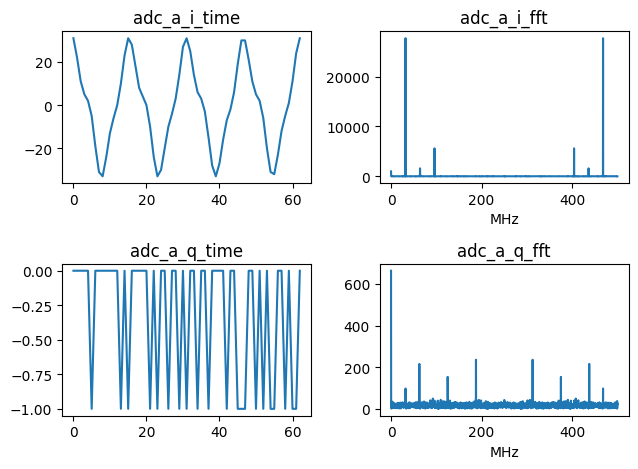

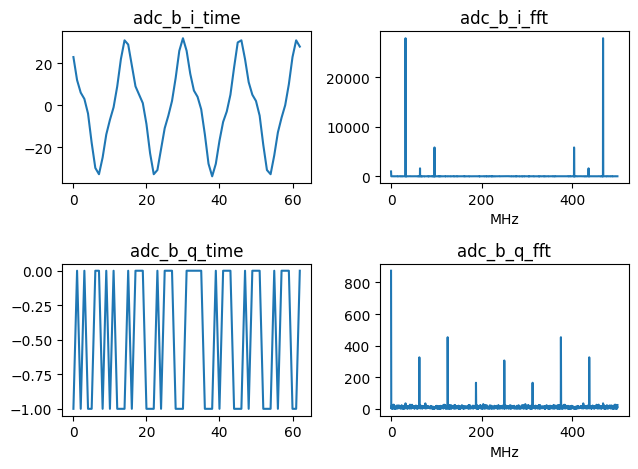

In [8]:
# define how many sample you want to plot
n_plot = 64
# Now, the script only supports 500MSps and 1000MSps
if(fs==1000):
    # combine the 4 data streams into 1 stream
    adc_a=[]
    adc_b=[]
    for i in range(len(adc_data)):
        adc_a.append(adc_raw[1][i])
        adc_a.append(adc_raw[0][i])
        adc_a.append(adc_raw[3][i])
        adc_a.append(adc_raw[2][i])
        adc_b.append(adc_raw[5][i])
        adc_b.append(adc_raw[4][i])
        adc_b.append(adc_raw[7][i])
        adc_b.append(adc_raw[6][i])
        '''
        for j in range(3,-1,-1):
            adc_a.append(adc_raw[j][i])
            adc_b.append(adc_raw[j+4][i])
        '''

    # cal x for the plot
    Nfft = len(adc_a)
    x=fs/Nfft*np.linspace(0,Nfft,Nfft)
    # plot adc_a_time and adc_a_fft
    plt_a_time = plt.subplot(2,1,1)
    plt.plot(adc_a[1:n_plot])
    plt.title('adc_a_time')
    plt_a_fft = plt.subplot(2,1,2)
    a = np.array(adc_a)
    fft_a = fft(a)
    plt.plot(x,abs(fft_a))
    plt.title('adc_a_fft')
    plt.xlabel('MHz')
    plt.tight_layout()
    plt.show()

    # plot adc_b_time and adc_b_fft
    plt_b_time = plt.subplot(2,1,1)
    plt.plot(adc_b[1:n_plot])
    plt.title('adc_b_time')
    plt_b_fft = plt.subplot(2,1,2)
    b = np.array(adc_b)
    fft_b = fft(b)
    plt.plot(x,abs(fft_b))
    plt.title('adc_b_fft')
    plt.xlabel('MHz')
    plt.tight_layout()
    plt.show()
elif(fs==500):
    # combine the 4 data streams into 2 streams
    adc_a_i = []
    adc_a_q = []
    adc_b_i = []
    adc_b_q = []
    for i in range(len(adc_data)):
        adc_a_i.append(adc_raw[3][i])
        adc_a_i.append(adc_raw[2][i])
        adc_a_q.append(adc_raw[1][i])
        adc_a_q.append(adc_raw[0][i])
        adc_b_i.append(adc_raw[7][i])
        adc_b_i.append(adc_raw[6][i])
        adc_b_q.append(adc_raw[5][i])
        adc_b_q.append(adc_raw[4][i])
    # cal x for the plot
    Nfft = len(adc_a_i)
    x=fs/Nfft*np.linspace(0,Nfft,Nfft)
    # plot adc_a_time and adc_a_fft
    plt_a_i_time = plt.subplot(2,2,1)
    plt.plot(adc_a_i[1:n_plot])
    plt.title('adc_a_i_time')
    plt_a_i_fft = plt.subplot(2,2,2)
    a_i = np.array(adc_a_i)
    fft_a_i = fft(a_i)
    plt.plot(x,abs(fft_a_i))
    plt.title('adc_a_i_fft')
    plt.xlabel('MHz')
    plt_a_q_time = plt.subplot(2,2,3)
    plt.plot(adc_a_q[1:n_plot])
    plt.title('adc_a_q_time')
    plt_a_q_fft = plt.subplot(2,2,4)
    a_q = np.array(adc_a_q)
    fft_a_q = fft(a_q)
    plt.plot(x,abs(fft_a_q))
    plt.title('adc_a_q_fft')
    plt.xlabel('MHz')
    plt.tight_layout()
    plt.show()

    # plot adc_b_time and adc_b_fft
    plt_b_i_time = plt.subplot(2,2,1)
    plt.plot(adc_b_i[1:n_plot])
    plt.title('adc_b_i_time')
    plt_b_i_fft = plt.subplot(2,2,2)
    b_i = np.array(adc_b_i)
    fft_b_i = fft(b_i)
    plt.plot(x,abs(fft_b_i))
    plt.title('adc_b_i_fft')
    plt.xlabel('MHz')
    plt_b_q_time = plt.subplot(2,2,3)
    plt.plot(adc_b_q[1:n_plot])
    plt.title('adc_b_q_time')
    plt_b_q_fft = plt.subplot(2,2,4)
    b_q = np.array(adc_b_q)
    fft_b_q = fft(b_q)
    plt.plot(x,abs(fft_b_q))
    plt.title('adc_b_q_fft')
    plt.xlabel('MHz')
    plt.tight_layout()
    plt.show()